# Load and Isolate the Nodule

Found 3 patient folders in ../test.

Processing patient 3304...

Processing patient 3304 from folder: ../test/3304
Saved CT scan (HU) for patient 3304 at: ../test_processed/3304/3304_full_volume.npy
CT volume loaded for patient 3304 with shape: (305, 512, 512)

Processing nodule index 24 for patient 3304
Displaying extracted nodule cube for nodule index 24.


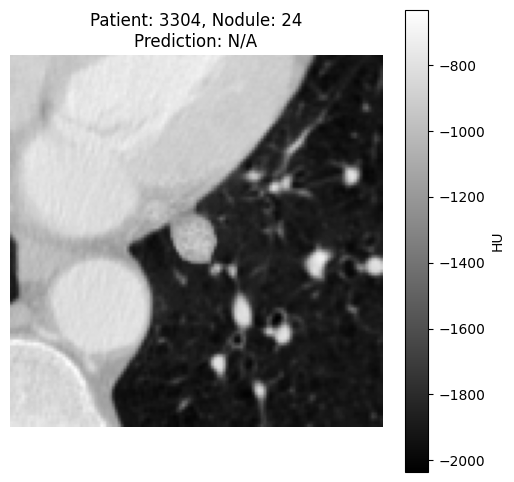

Displaying 2D Magic Wand mask for nodule index 24 on slice 129.


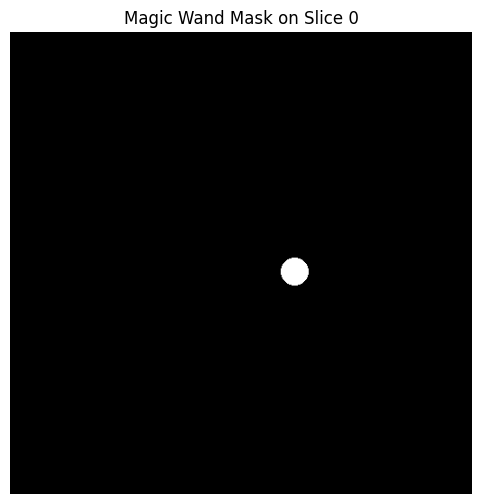

Processing slices 124 to 134 for seed slice 129.
Displaying 3D Magic Wand mask for nodule index 24 on seed slice 129.


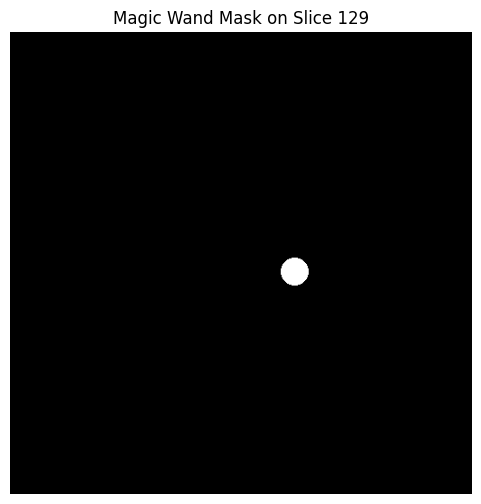

Displaying ASRG mask for nodule index 24 on slice 129.


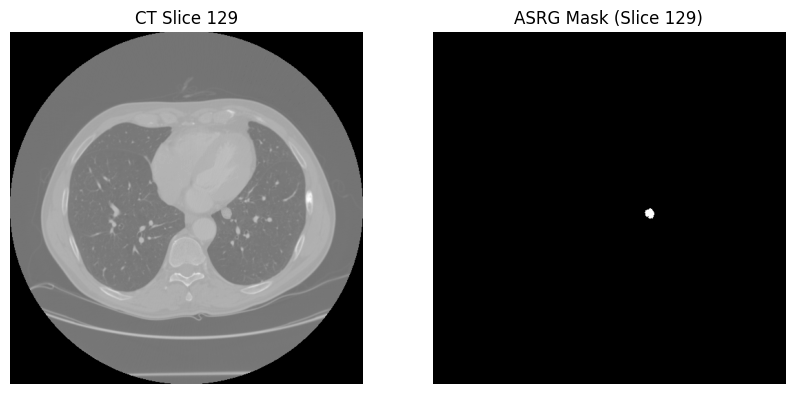

Saved ASRG mask for nodule index 24 at: ../test_processed/3304/24_asrg_mask.npy

Processing patient 2190...

Processing patient 2190 from folder: ../test/2190
Saved CT scan (HU) for patient 2190 at: ../test_processed/2190/2190_full_volume.npy
CT volume loaded for patient 2190 with shape: (280, 512, 512)

Processing nodule index 61 for patient 2190
Displaying extracted nodule cube for nodule index 61.


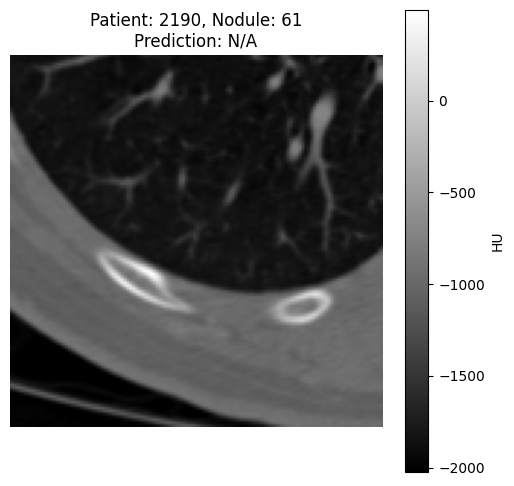

Displaying 2D Magic Wand mask for nodule index 61 on slice 48.


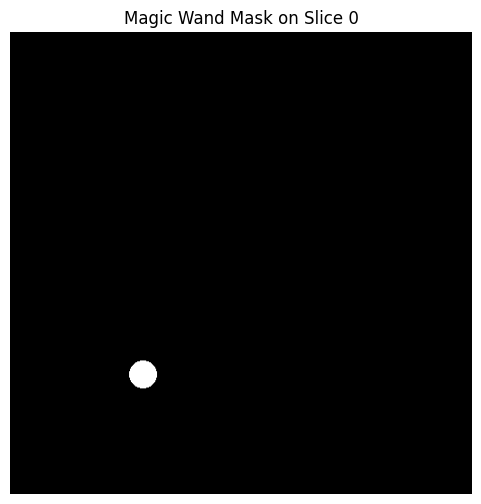

Processing slices 43 to 53 for seed slice 48.
Displaying 3D Magic Wand mask for nodule index 61 on seed slice 48.


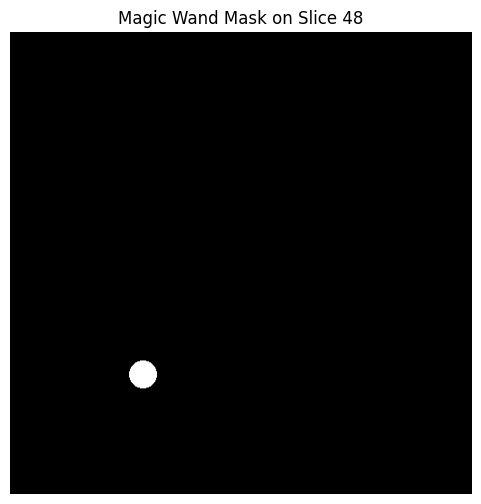

Displaying ASRG mask for nodule index 61 on slice 48.


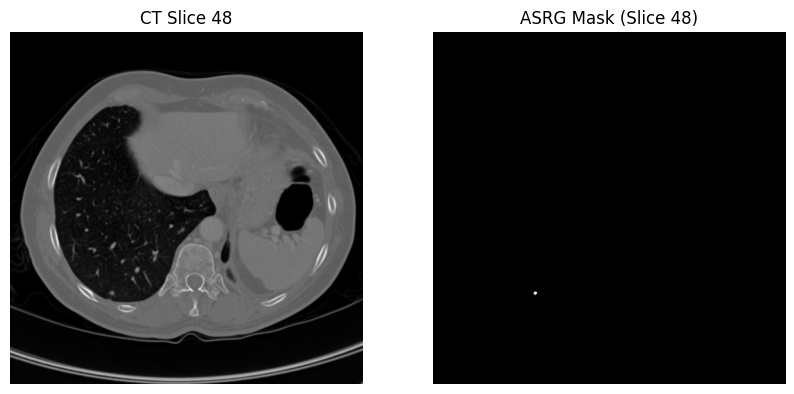

Saved ASRG mask for nodule index 61 at: ../test_processed/2190/61_asrg_mask.npy

Processing nodule index 62 for patient 2190
Displaying extracted nodule cube for nodule index 62.


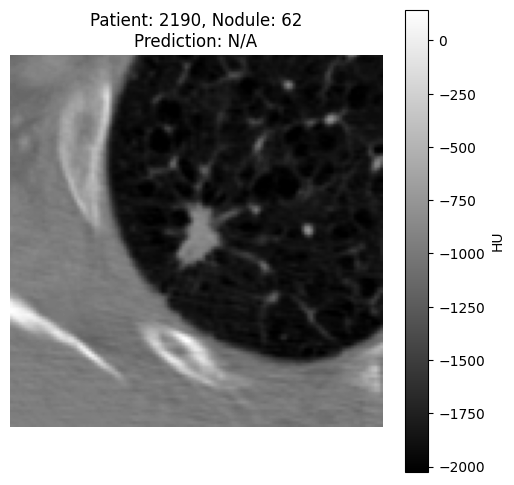

Displaying 2D Magic Wand mask for nodule index 62 on slice 213.


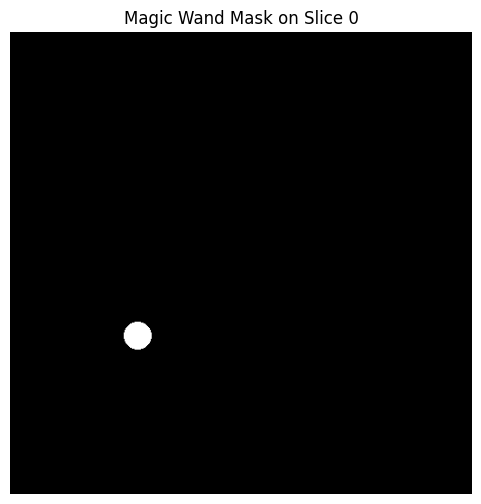

Processing slices 208 to 218 for seed slice 213.
Displaying 3D Magic Wand mask for nodule index 62 on seed slice 213.


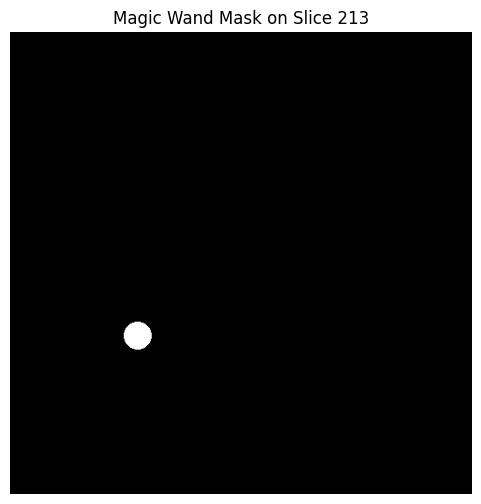

Displaying ASRG mask for nodule index 62 on slice 213.


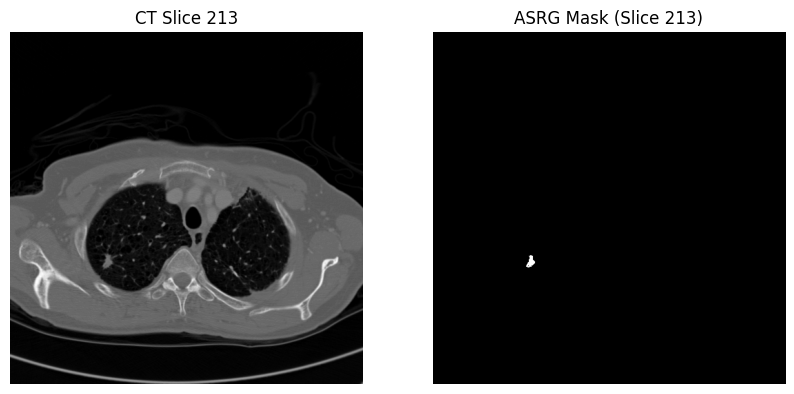

Saved ASRG mask for nodule index 62 at: ../test_processed/2190/62_asrg_mask.npy

Processing patient 2131...

Processing patient 2131 from folder: ../test/2131
Saved CT scan (HU) for patient 2131 at: ../test_processed/2131/2131_full_volume.npy
CT volume loaded for patient 2131 with shape: (276, 512, 512)

Processing nodule index 56 for patient 2131
Displaying extracted nodule cube for nodule index 56.


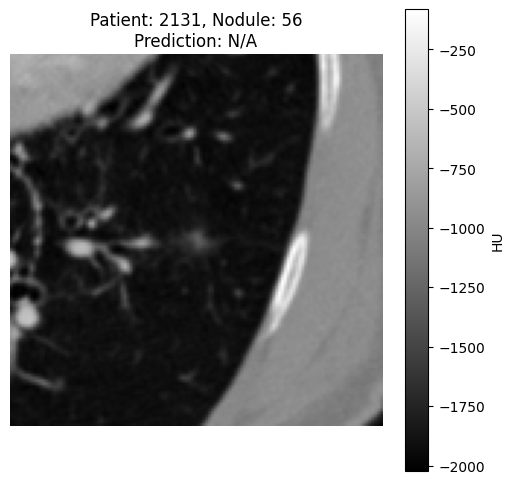

Displaying 2D Magic Wand mask for nodule index 56 on slice 103.


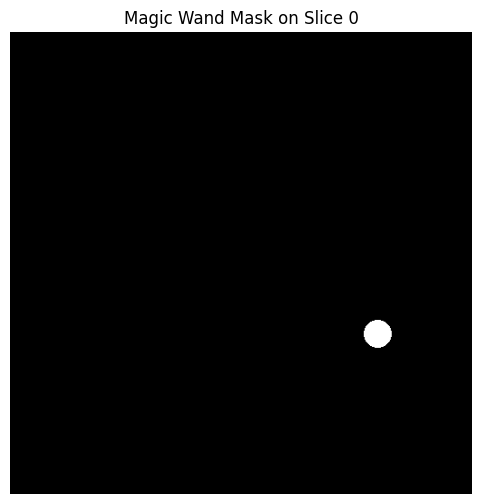

Processing slices 98 to 108 for seed slice 103.
Displaying 3D Magic Wand mask for nodule index 56 on seed slice 103.


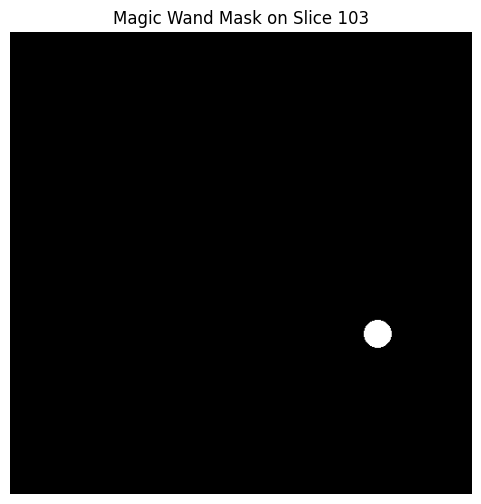

Displaying ASRG mask for nodule index 56 on slice 103.


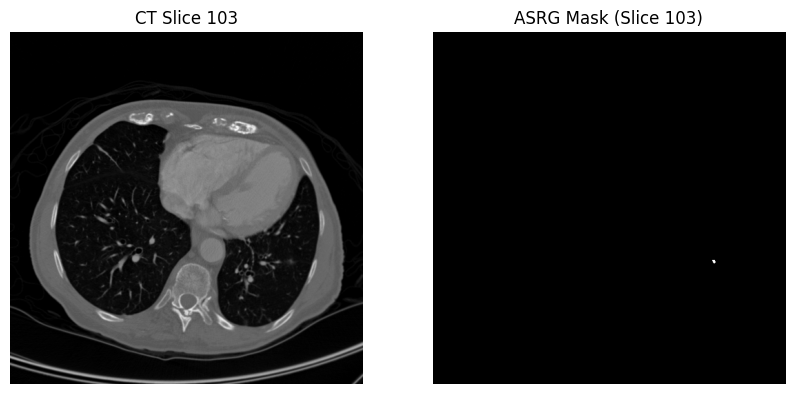

Saved ASRG mask for nodule index 56 at: ../test_processed/2131/56_asrg_mask.npy

Processing nodule index 57 for patient 2131
Displaying extracted nodule cube for nodule index 57.


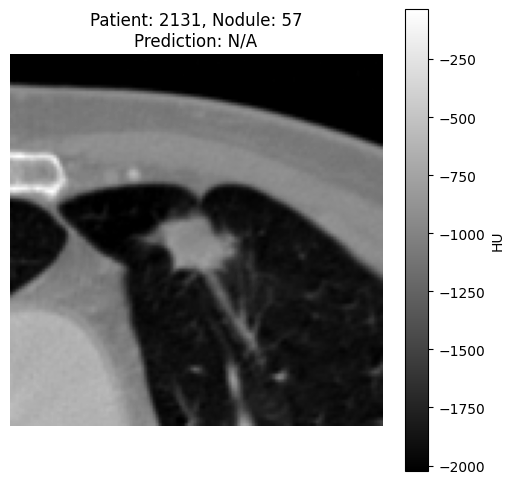

Displaying 2D Magic Wand mask for nodule index 57 on slice 198.


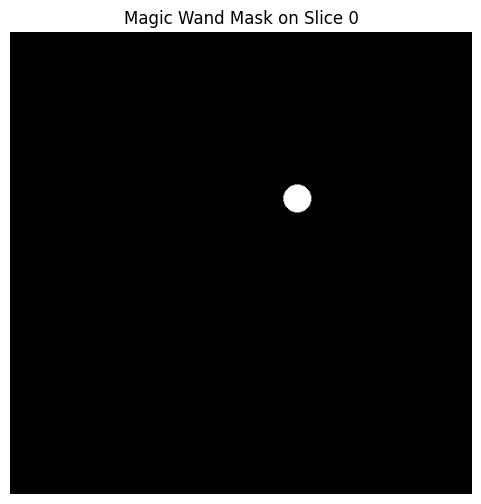

Processing slices 193 to 203 for seed slice 198.
Displaying 3D Magic Wand mask for nodule index 57 on seed slice 198.


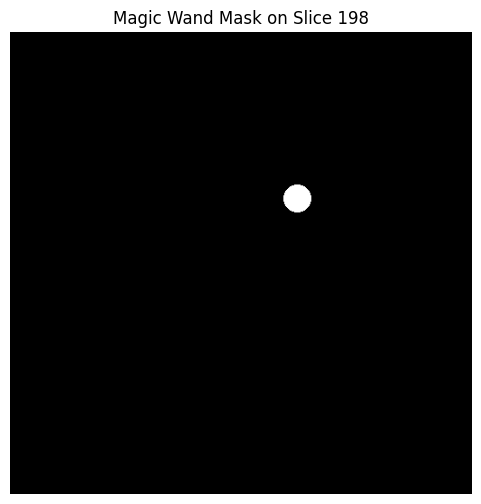

Displaying ASRG mask for nodule index 57 on slice 198.


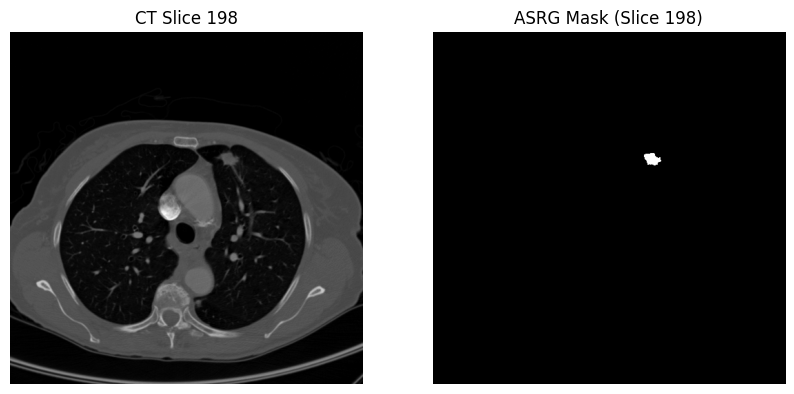

Saved ASRG mask for nodule index 57 at: ../test_processed/2131/57_asrg_mask.npy

Processing nodule index 58 for patient 2131
Displaying extracted nodule cube for nodule index 58.


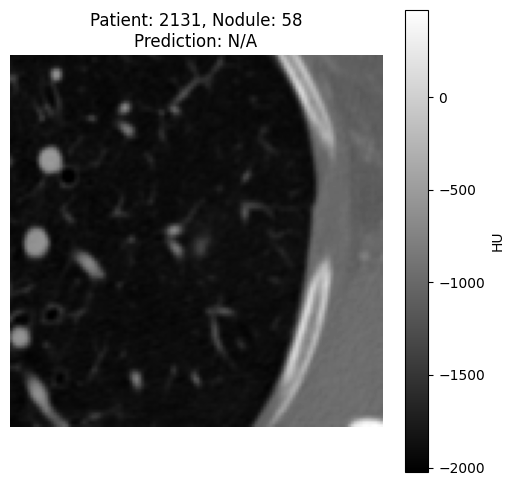

Displaying 2D Magic Wand mask for nodule index 58 on slice 211.


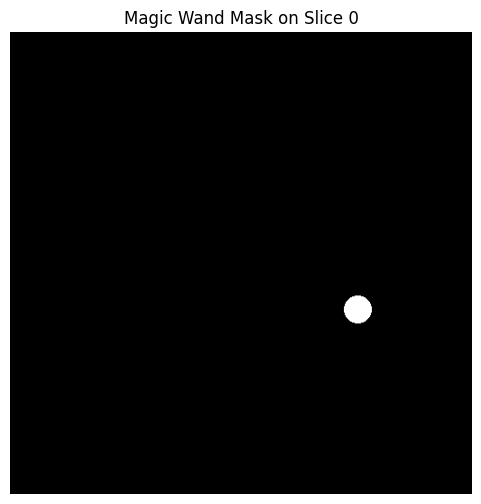

Processing slices 206 to 216 for seed slice 211.
Displaying 3D Magic Wand mask for nodule index 58 on seed slice 211.


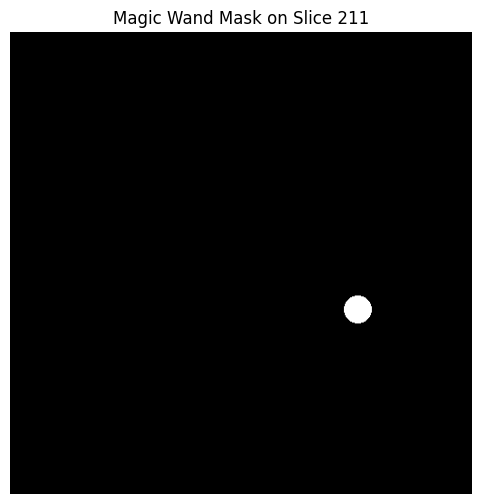

Displaying ASRG mask for nodule index 58 on slice 211.


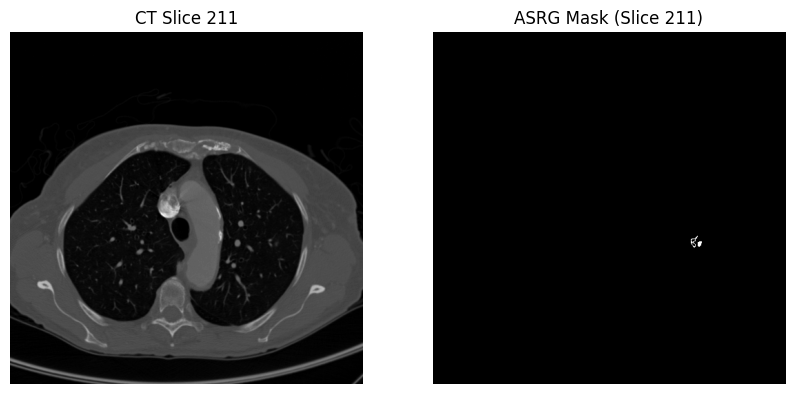

Saved ASRG mask for nodule index 58 at: ../test_processed/2131/58_asrg_mask.npy


In [1]:
import os
import numpy as np
import pandas as pd

# Import our custom modules
from modules.test_modules import load_and_save, cmw_asrg

# -------------------------------
# Base directories and CSV path
# -------------------------------
test_dir = os.path.join("..", "test")             # Contains patient DICOM folders
output_base = os.path.join("..", "test_processed")  # Where processed volumes and masks will be saved
csv_path = os.path.join("..", "test", "CombinedCancerList.csv")

# Load the global CSV with nodule coordinates.
df_coords = pd.read_csv(csv_path)

# Get list of all patient directories in the test folder.
patient_ids = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
print(f"Found {len(patient_ids)} patient folders in {test_dir}.")

# Loop over each patient folder.
for patient_id in patient_ids:
    print(f"\nProcessing patient {patient_id}...")
    
    # Define input and output directories.
    dicom_dir = os.path.join(test_dir, patient_id)
    output_dir = os.path.join(output_base, patient_id)
    
    # Process the CT scan: load DICOM series, convert to HU, and save volume.
    load_and_save.process_patient_scan(dicom_dir, patient_id, output_dir)
    
    # Load the processed CT volume.
    npy_filename = f"{patient_id}_full_volume.npy"
    npy_path = os.path.join(output_dir, npy_filename)
    if not os.path.isfile(npy_path):
        print(f"Processed CT volume for patient {patient_id} not found, skipping.")
        continue
    ct_volume = np.load(npy_path)
    print(f"CT volume loaded for patient {patient_id} with shape: {ct_volume.shape}")
    
    # Filter the CSV for nodules corresponding to this patient.
    df_patient = df_coords[df_coords["uuid"].astype(str) == patient_id]
    if df_patient.empty:
        print(f"No nodule data found for patient {patient_id} in {csv_path}.")
        continue
    
    # Process each nodule for this patient.
    for idx, row in df_patient.iterrows():
        print(f"\nProcessing nodule index {idx} for patient {patient_id}")
        seed_slice = int(row["slice"])
        x_center = int(row["x"])
        y_center = int(row["y"])
        # Define the center as (z, y, x)
        center = (seed_slice, y_center, x_center)
        
        # Extract a 128x128x128 cube around the cancer location.
        cube = load_and_save.extract_cube(ct_volume, center, cube_size=(128, 128, 128))
        print(f"Displaying extracted nodule cube for nodule index {idx}.")
        load_and_save.display_middle_slice(cube, patient_id, idx, predicted_class="N/A")
        
        # -------------------------------
        # 3. 2D Magic Wand Segmentation
        # -------------------------------
        slice_img = ct_volume[seed_slice]
        # Segmentation parameters (example values)
        min_radius = 15
        max_radius = 20
        roughness = 2
        zoom_factor = 1
        center_range = 2
        
        mask_2d = cmw_asrg.cell_magic_wand(slice_img, (y_center, x_center),
                                            min_radius, max_radius,
                                            roughness=roughness, zoom_factor=zoom_factor,
                                            center_range=center_range)
        print(f"Displaying 2D Magic Wand mask for nodule index {idx} on slice {seed_slice}.")
        # Wrap the 2D mask as a 3D volume to display.
        cmw_asrg.display_mask_slice(np.expand_dims(mask_2d, axis=0), 0)
        
        # -------------------------------
        # 4. 3D Magic Wand Segmentation
        # -------------------------------
        slices_above_below = 5  # Number of slices to include above and below the seed.
        cancer_mask_3d = cmw_asrg.create_3d_cancer_mask(ct_volume, seed_slice, (y_center, x_center),
                                                         min_radius, max_radius,
                                                         roughness, zoom_factor, center_range, slices_above_below)
        print(f"Displaying 3D Magic Wand mask for nodule index {idx} on seed slice {seed_slice}.")
        cmw_asrg.display_mask_slice(cancer_mask_3d, seed_slice)
        
        # -------------------------------
        # 5. Automated Seeded Region Growing (ASRG)
        # -------------------------------
        try:
            seed_asrg = cmw_asrg.get_seed_point(cancer_mask_3d)
        except Exception as e:
            print(f"Error obtaining ASRG seed for nodule {idx}: {e}")
            continue
        asrg_threshold = 200  # Intensity threshold (adjust as needed)
        asrg_mask = cmw_asrg.region_growing(ct_volume, cancer_mask_3d, seed_asrg, threshold=asrg_threshold)
        asrg_mask = (asrg_mask > 0).astype(np.uint8)
        print(f"Displaying ASRG mask for nodule index {idx} on slice {seed_asrg[0]}.")
        cmw_asrg.display_extracted_region(ct_volume, asrg_mask, seed_asrg[0])
        
        # -------------------------------
        # 6. Save the ASRG Mask
        # -------------------------------
        asrg_filename = f"{idx}_asrg_mask.npy"
        asrg_path = os.path.join(output_dir, asrg_filename)
        np.save(asrg_path, asrg_mask)
        print(f"Saved ASRG mask for nodule index {idx} at: {asrg_path}")


# Extract Features for Testing

## Shape Based Features

In [19]:
import os
import numpy as np
import pandas as pd

# Import the shape-based feature extraction function.
from modules.shape_features import extract_nodule_features

# Base directory where processed CT scans and masks are saved.
processed_root = "../test_processed"

# List to store features from each nodule.
all_features = []

# Iterate over each patient directory directly under processed_root.
patient_dirs = [
    os.path.join(processed_root, d) for d in os.listdir(processed_root)
    if os.path.isdir(os.path.join(processed_root, d))
]

for patient_dir in patient_dirs:
    patient_id = os.path.basename(patient_dir)
    # Look for nodule masks: try ASRG masks first; if none, try CMW masks.
    mask_files = [f for f in os.listdir(patient_dir) if f.endswith("_asrg_mask.npy")]
    if not mask_files:
        mask_files = [f for f in os.listdir(patient_dir) if f.endswith("_cmw_mask.npy")]
    if not mask_files:
        print(f"No nodule masks found for patient {patient_id} in {patient_dir}.")
        continue

    # Process each nodule mask.
    for mask_file in mask_files:
        # Assume the mask filename is like "1_asrg_mask.npy" or "1_cmw_mask.npy"
        nodule_number = mask_file.split("_")[0]
        mask_path = os.path.join(patient_dir, mask_file)
        try:
            mask = np.load(mask_path)
        except Exception as e:
            print(f"Error loading mask {mask_file} for patient {patient_id}: {e}")
            continue

        # Extract shape-based features (adjust spacing if needed).
        shape_feats = extract_nodule_features(mask, spacing=(1, 1, 1))
        
        # Build the feature dictionary including nodule number and patient id.
        feature_dict = {
            "nodule_number": nodule_number,
            "patient_id": patient_id
        }
        feature_dict.update(shape_feats)
        
        # Remove keys we don't want to save.
        for key in ["wavelet_entropy_level_1", "intensity_std"]:
            if key in feature_dict:
                feature_dict.pop(key)
                
        all_features.append(feature_dict)

# Create a DataFrame from the collected features.
df_shape = pd.DataFrame(all_features)

# Save the features to a CSV file at the processed_root.
output_csv_path = os.path.join(processed_root, "test_features.csv")
df_shape.to_csv(output_csv_path, index=False)
print(f"Shape feature extraction complete. CSV saved at: {output_csv_path}")


Shape feature extraction complete. CSV saved at: ../test_processed/test_features.csv


## Texture Based Features

In [22]:
import os
import numpy as np
import pandas as pd

# Import the texture-based feature extraction function and the bounding box helper.
from modules.texture_features import extract_texture_features
from modules.artifact_noise_features import get_bounding_box

# Base directory for processed data.
data_processed_root = "../test_processed"

# Path to the existing features CSV (from the shape-based step).
csv_path = os.path.join(data_processed_root, "test_features.csv")

# Load the existing features DataFrame.
df = pd.read_csv(csv_path)

# List to store texture feature dictionaries.
texture_feature_list = []

# Iterate over each row in the CSV.
for index, row in df.iterrows():
    # Convert patient_id to integer (if possible) then to string to avoid decimal representation.
    try:
        patient_id = str(int(float(row['patient_id'])))
    except Exception as e:
        patient_id = str(row['patient_id'])
    
    # Similarly, ensure nodule_number is a clean string.
    try:
        nodule_number = str(int(float(row['nodule_number'])))
    except Exception as e:
        nodule_number = str(row['nodule_number'])
    
    # Use class information if available; otherwise, assume patient folder is directly under processed_root.
    cls = str(row['class']) if 'class' in row else ""
    
    if cls:
        patient_dir = os.path.join(data_processed_root, cls, patient_id)
    else:
        patient_dir = os.path.join(data_processed_root, patient_id)
        
    ct_scan_path = os.path.join(patient_dir, f"{patient_id}_full_volume.npy")
    
    if not os.path.isfile(ct_scan_path):
        print(f"CT scan not found for patient {patient_id}. Skipping row.")
        texture_feature_list.append({})
        continue
    ct_volume = np.load(ct_scan_path)
    
    # Look for the nodule mask: first try ASRG, then fall back to CMW.
    mask_filename = f"{nodule_number}_asrg_mask.npy"
    mask_path = os.path.join(patient_dir, mask_filename)
    if not os.path.isfile(mask_path):
        mask_filename = f"{nodule_number}_cmw_mask.npy"
        mask_path = os.path.join(patient_dir, mask_filename)
        if not os.path.isfile(mask_path):
            print(f"Mask not found for patient {patient_id}, nodule {nodule_number}. Skipping row.")
            texture_feature_list.append({})
            continue
    mask = np.load(mask_path)
    
    # Use the bounding box of the mask to extract the ROI from the CT scan.
    bbox = get_bounding_box(mask)
    if bbox is None:
        print(f"No nodule found in mask for patient {patient_id}, nodule {nodule_number}. Skipping row.")
        texture_feature_list.append({})
        continue
    roi = ct_volume[bbox]
    
    # Extract texture-based features from the ROI.
    texture_feats = extract_texture_features(roi)
    texture_feature_list.append(texture_feats)

# Convert the texture feature dictionaries into a DataFrame.
df_texture = pd.DataFrame(texture_feature_list)

# Append the new texture columns to the original DataFrame.
df_updated = pd.concat([df, df_texture], axis=1)

# Save the updated DataFrame back to the existing CSV.
df_updated.to_csv(csv_path, index=False)
print(f"Texture-based feature extraction complete. Updated CSV saved at: {csv_path}")


Texture-based feature extraction complete. Updated CSV saved at: ../test_processed/test_features.csv


## Intensity Based Features

In [25]:
import os
import numpy as np
import pandas as pd

# Import the intensity-based feature extraction function.
from modules.statistic_features import extract_intensity_features
# Reuse the bounding box helper from the artifact_noise_features module.
from modules.artifact_noise_features import get_bounding_box

# Base directory for processed data.
data_processed_root = "../test_processed"

# Path to the existing features CSV file (from the shape-based or previous steps).
csv_path = os.path.join(data_processed_root, "test_features.csv")

# Load the existing DataFrame.
df = pd.read_csv(csv_path)

# List to store intensity feature dictionaries.
intensity_feature_list = []

# Iterate over each row in the CSV.
for index, row in df.iterrows():
    # Convert patient_id and nodule_number to integer strings to avoid decimal representations.
    try:
        patient_id = str(int(float(row['patient_id'])))
    except Exception as e:
        patient_id = str(row['patient_id'])
    try:
        nodule_number = str(int(float(row['nodule_number'])))
    except Exception as e:
        nodule_number = str(row['nodule_number'])
    
    # Use class information if available; otherwise, assume the patient folder is directly under data_processed_root.
    cls = str(row['class']) if 'class' in row else ""
    if cls:
        patient_dir = os.path.join(data_processed_root, cls, patient_id)
    else:
        patient_dir = os.path.join(data_processed_root, patient_id)
    
    # Build the CT scan path.
    ct_scan_path = os.path.join(patient_dir, f"{patient_id}_full_volume.npy")
    if not os.path.isfile(ct_scan_path):
        print(f"CT scan not found for patient {patient_id}. Skipping row.")
        intensity_feature_list.append({})
        continue
    ct_volume = np.load(ct_scan_path)
    
    # Look for the nodule mask: first try ASRG, then fall back to CMW.
    mask_filename = f"{nodule_number}_asrg_mask.npy"
    mask_path = os.path.join(patient_dir, mask_filename)
    if not os.path.isfile(mask_path):
        mask_filename = f"{nodule_number}_cmw_mask.npy"
        mask_path = os.path.join(patient_dir, mask_filename)
        if not os.path.isfile(mask_path):
            print(f"Mask not found for patient {patient_id}, nodule {nodule_number}. Skipping row.")
            intensity_feature_list.append({})
            continue
    mask = np.load(mask_path)
    
    # Use the bounding box of the mask to extract the ROI from the CT scan.
    bbox = get_bounding_box(mask)
    if bbox is None:
        print(f"No nodule found in mask for patient {patient_id}, nodule {nodule_number}. Skipping row.")
        intensity_feature_list.append({})
        continue
    roi = ct_volume[bbox]
    
    # Extract intensity-based features (statistical moments and histogram features).
    intensity_feats = extract_intensity_features(roi, num_bins=50)
    intensity_feature_list.append(intensity_feats)

# Convert the list of intensity feature dictionaries into a DataFrame.
df_intensity = pd.DataFrame(intensity_feature_list)

# Append the new intensity feature columns to the original DataFrame.
df_updated = pd.concat([df, df_intensity], axis=1)

# Save the updated DataFrame back to the existing CSV.
df_updated.to_csv(csv_path, index=False)
print(f"Intensity-based feature extraction complete. Updated CSV saved at: {csv_path}")


Intensity-based feature extraction complete. Updated CSV saved at: ../test_processed/test_features.csv


# Perform Classification

In [14]:
import os
import pandas as pd
import joblib

# -------------------------------
# Load the saved Random Forest model
# -------------------------------
model_path = os.path.join("..", "models", "random_forest_model.pkl")
model = joblib.load(model_path)
print(f"Loaded model from {model_path}")

# -------------------------------
# Load test features from CSV
# -------------------------------
test_features_csv = os.path.join("..", "test_processed", "test_features.csv")
df_test = pd.read_csv(test_features_csv)
print(f"Loaded test features from {test_features_csv}")

# -------------------------------
# Prepare the features for prediction
# -------------------------------
# Remove non-feature columns (adjust if your CSV includes additional metadata)
non_feature_cols = ["nodule_number", "patient_id"]
X_test = df_test.drop(columns=non_feature_cols, errors="ignore")

# -------------------------------
# Align test features with the model's expected features
# -------------------------------
# Use model.feature_names_in_ (available in scikit-learn 1.0+) to determine expected columns.
if hasattr(model, "feature_names_in_"):
    expected_features = model.feature_names_in_
    # Add any missing columns with default value 0.0
    for col in expected_features:
        if col not in X_test.columns:
            X_test[col] = 0.0
    # Drop any extra columns that were not used during training.
    X_test = X_test[expected_features]
else:
    print("Warning: The model does not have feature_names_in_ attribute. Ensure that the test features match the training features.")

# -------------------------------
# Run predictions using the model
# -------------------------------
predictions = model.predict(X_test)

# Map numeric predictions to class labels if needed.
# Here we assume: 0 = RealCancerous and 1 = FakeAddedCancer.
label_map = {0: "RealCancerous", 1: "FakeAddedCancer"}
predicted_labels = [label_map.get(pred, pred) for pred in predictions]

# Add predictions to the DataFrame.
df_test["predicted_class"] = predicted_labels

# -------------------------------
# Display and save the predictions
# -------------------------------
print("Predictions for test scan:")
print(df_test[["patient_id", "nodule_number", "predicted_class"]])

output_predictions_csv = os.path.join("..", "test_processed", "test_predictions.csv")
df_test.to_csv(output_predictions_csv, index=False)
print(f"Predictions saved to {output_predictions_csv}")


Loaded model from ../models/random_forest_model.pkl
Loaded test features from ../test_processed/test_features.csv
Predictions for test scan:
   patient_id  nodule_number  predicted_class
0        3304             24  FakeAddedCancer
1        2190             61    RealCancerous
2        2190             62    RealCancerous
3        3246             22  FakeAddedCancer
4        2131             57    RealCancerous
5        2131             56    RealCancerous
6        2131             58    RealCancerous
Predictions saved to ../test_processed/test_predictions.csv
